### <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFA500"><b><span style='color:#FFA500'></span></b> <b>1. Initial Setting</b></div>

#### <b><span style='color:#FFA500'> | </span> Import Libraries</b>

In [1]:
import os
import gc 
import ctypes
import random
import time
import string
import re
from tqdm import tqdm
import pickle

import pandas as pd, numpy as np
import polars as pl # For Feature Engineering

import matplotlib.pyplot as plt
import seaborn as sns 

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import words
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import VotingRegressor

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1' # For GPU T4x2

import warnings 
warnings.filterwarnings('ignore')

#### <b><span style='color:#FFA500'> | </span> Configure</b>

In [2]:
class CFG:
    SEED = 2024
    VER = 1
    LOAD_MODELS_FROM = '/kaggle/input/aes2-cat/'
    LOAD_FEATURES_FROM = '/kaggle/input/aes2-cat/train_feats_1.csv'
    BASE_PATH = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/'

#### <b><span style='color:#FFA500'> | </span> Clean Memory</b>

In [3]:
Clean = True

def clean_memory():
    if Clean:
        ctypes.CDLL('libc.so.6').malloc_trim(0)
        gc.collect()
        
clean_memory()  

#### <b><span style='color:#FFA500'> | </span> Seed Everything</b>

In [4]:
def seed_everything(): # To proudce simliar result in each run 
    random.seed(CFG.SEED)
    np.random.seed(CFG.SEED)
    os.environ['PYTHONHASHSEED'] = str(CFG.SEED)
    
seed_everything()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFA500"><b><span style='color:#FFA500'></span></b> <b>2. Road and Read Data</b></div>

In [5]:
def seed_everything(): # To proudce simliar result in each run 
    random.seed(CFG.SEED)
    np.random.seed(CFG.SEED)
    os.environ['PYTHONHASHSEED'] = str(CFG.SEED)
    
seed_everything()

In [6]:
df_train = pd.read_csv(CFG.BASE_PATH + 'train.csv')
df_train = df_train.sort_values(by='essay_id')

print('Shape of Train: ', df_train.shape)
print(display(df_train.head()))

Shape of Train:  (17307, 3)


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


None


In [7]:
df_test = pd.read_csv(CFG.BASE_PATH + 'test.csv')
df_test = df_test.sort_values(by='essay_id')

print('Shape of Test: ', df_test.shape)
print(display(df_test.head()))

Shape of Test:  (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


None


In [8]:
# os.path.join(CFG.BASE_PATH,'train.csv')
# CFG.BASE_PATH + 'train.csv'

train = pl.from_pandas(df_train).with_columns(
    pl.col('full_text').str.split(by='\n\n').alias('paragraph'))
test = pl.from_pandas(df_test).with_columns(
    pl.col('full_text').str.split(by='\n\n').alias('paragraph')
)

schema_train = train.schema # MetaData
schema_test = test.schema # MetaData

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFA500"><b><span style='color:#FFA500'></span></b> <b>3. FeatureGenerator</b></div>

📌 **Features & TFIDF**

https://www.kaggle.com/code/ye11725/tfidf-lgbm-baseline-with-code-comments

In [9]:
def removeHTML(x):
    html = re.compile(r'<.*?>')
    return html.sub(r'',x) # html -> ''

def dataPreprocessing(x):
    
    x = x.lower()
    # remove html
    x = removeHTML(x)
    
    #remove string with starting @
    x = re.sub("@\w+",'',x)
    
    # remove number
    x = re.sub("'\d+",'',x)
    x = re.sub("\d+",'',x)
    
    # remove url
    x = re.sub("http\w+",'',x)
    
    # Replace consecutive empty spaces with a single empty spaces
    x = re.sub(r'\s+', " ", x)
    x = re.sub(r'[^\w\s.,;:"''?!]', '', x)
    x = re.sub("paragraph", "", x)
    # x = re.sub('\n\n', "", x)
    # Replace consecutive commas and periods with a single comma and period
    x = re.sub(r'\.+', ".",x)
    x = re.sub(r'\,+', ",",x)
    # Remove empty character at the beginning and end
    x = x.strip()
    return x

In [10]:
!pip install -q --no-index /kaggle/input/aes-2-misspelled-whl/pyspellchecker-0.8.1-py3-none-any.whl

In [11]:
from spellchecker import SpellChecker

spell = SpellChecker()
def count_misspelled_words(text):
    misspelled_words = spell.unknown(text.split())
    return len(misspelled_words)

In [12]:
paragraph_features = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt',"paragraph_comma_cnt",'paragraph_misspelled_cnt']

def Paragraph_Features(x):
    # Expand the paragraph list to several lines of data
    x = x.explode('paragraph') 
   
    print('Paragraph Preprocessing')
    x = x.with_columns(
         pl.col('paragraph').map_elements(dataPreprocessing)
    )
    print('Caculate the length of each paragraph')
    x = x.with_columns(
         pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len")
    )
    x = x.with_columns(
         pl.col('paragraph').map_elements(lambda x: count_misspelled_words(x)).alias('paragraph_misspelled_cnt')
    )
    x = x.with_columns(
         pl.col('paragraph').map_elements(lambda x: x.count(',')).alias("paragraph_comma_cnt")
    )
    print('Caculate the number of sentences and words in each paragraph')
    x = x.with_columns(
         pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias('paragraph_sentence_cnt'),
         pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias('paragraph_word_cnt')
    )
    return x

def Paragraph_aggregation(x):    
    
    print('Aggregation')
    aggs = [
    *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f'paragraph_{i}_cnt') for i in [100,150, 200, 250, 300, 350, 400, 450, 500, 600, 800]],
    *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f'paragraph_{i}_cnt_v2') for i in [100,200]],
    *[pl.col('paragraph').filter((pl.col('paragraph_len') <= 300) & (pl.col('paragraph_len') > 100)).count().alias(f'short_paragraph_cnt')],    
    *[pl.col('paragraph').filter((pl.col('paragraph_len') <= 500) & (pl.col('paragraph_len') > 300)).count().alias(f'mid_paragraph_cnt')],
    *[pl.col('paragraph').filter((pl.col('paragraph_len') <= 700) & (pl.col('paragraph_len') > 500)).count().alias(f'long_paragraph_cnt')],
    *[pl.col('paragraph').filter(pl.col('paragraph_sentence_cnt') >= i).count().alias(f'paragraph_sentence_{i}_cnt') for i in [2,4,6,8,10]],
    *[pl.col('paragraph').filter((pl.col('paragraph_sentence_cnt') <= 4) & (pl.col('paragraph_sentence_cnt') > 2)).count().alias(f'short_paragraph_sentence_cnt')],
    *[pl.col('paragraph').filter((pl.col('paragraph_sentence_cnt') <= 8) & (pl.col('paragraph_sentence_cnt') > 4)).count().alias(f'mid_paragraph_sentence_cnt')],
    *[pl.col('paragraph').filter((pl.col('paragraph_sentence_cnt') <= 10) & (pl.col('paragraph_sentence_cnt') > 8)).count().alias(f'long_paragraph_sentence_cnt')],    
    *[pl.col('paragraph').filter(pl.col('paragraph_word_cnt') >= i).count().alias(f'paragraph_word_{i}_cnt') for i in [20,40,60,90,120]],
    *[pl.col('paragraph').filter((pl.col('paragraph_word_cnt') <= 40) & (pl.col('paragraph_word_cnt') > 20)).count().alias(f'short_paragraph_word_cnt')],
    *[pl.col('paragraph').filter((pl.col('paragraph_word_cnt') <= 90) & (pl.col('paragraph_word_cnt') > 40)).count().alias(f'mid_paragraph_word_cnt')],
    *[pl.col('paragraph').filter((pl.col('paragraph_word_cnt') <= 120) & (pl.col('paragraph_word_cnt') > 90)).count().alias(f'long_paragraph_word_cnt')],
    *[pl.col('paragraph').filter(pl.col('paragraph_comma_cnt') >= i).count().alias(f'paragraph_comma_{i}_cnt') for i in [1,2,3,4,5]],
    *[pl.col('paragraph').filter(pl.col('paragraph_misspelled_cnt') >= i).count().alias(f'paragraph_misspelled_{i}_cnt') for i in [4,8,12,16]],
    *[pl.col('paragraph').filter(pl.col('paragraph_misspelled_cnt') <= i).count().alias(f'paragraph_misspelled_{i}_cnt_v2') for i in [2,4]],
    *[pl.col('paragraph').filter((pl.col('paragraph_misspelled_cnt') <= 8) & (pl.col('paragraph_misspelled_cnt') > 4)).count().alias(f'short_paragraph_misspelled_cnt')],
    *[pl.col('paragraph').filter((pl.col('paragraph_misspelled_cnt') <= 12) & (pl.col('paragraph_misspelled_cnt') > 8)).count().alias(f'mid_paragraph_misspelled_cnt')],
    *[pl.col('paragraph').filter((pl.col('paragraph_misspelled_cnt') <= 16) & (pl.col('paragraph_misspelled_cnt') > 12)).count().alias(f'long_paragraph_misspelled_cnt')],
    *[pl.col('paragraph').count().alias('paragraph_cnt')], 
    *[pl.col(feat).max().alias(f'{feat}_max') for feat in paragraph_features],
    *[pl.col(feat).mean().alias(f'{feat}_mean') for feat in paragraph_features],
    *[pl.col(feat).min().alias(f'{feat}_min') for feat in paragraph_features],
    *[pl.col(feat).std().alias(f'{feat}_std') for feat in paragraph_features],
    *[pl.col(feat).sum().alias(f'{feat}_sum') for feat in paragraph_features],
    *[pl.col(feat).quantile(0.25).alias(f'{feat}_q1') for feat in paragraph_features],
    *[pl.col(feat).quantile(0.75).alias(f'{feat}_q3') for feat in paragraph_features],   
    ]
      
    df = x.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas() # polars -> pandas
    
    return df

In [13]:
sentence_features = ['sentence_len','sentence_word_cnt']

def Sentence_Features(x):
    print('Preprocess full_text and use periods to segment sentences in the text')
    x = x.with_columns(
        pl.col('full_text').map_elements(lambda x: dataPreprocessing(x)).str.split(".").alias('sentence')
    )
    x = x.explode('sentence')
    
    print('Caculate the length of a sentence') 
    x = x.with_columns(
        pl.col('sentence').map_elements(lambda x: len(x)).alias('sentence_len'))
    x = x.filter(pl.col('sentence_len') > 3)
    x = x.with_columns(
       pl.col('sentence').map_elements(lambda x: len(x.replace(' ', ''))).alias('only_sentence_len'))
    print('Count the number of words in each sentence')
    x = x.with_columns(
        pl.col('sentence').map_elements(lambda x: len(x.split(" "))).alias("sentence_word_cnt"))
    return x

def Sentence_aggregation(x):    
    
    print('Aggregation')
    aggs = [
    *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f'sentence_{i}_cnt') for i in [40,60,70,80,100,120,140]],    
    *[pl.col('sentence').filter(pl.col('sentence_len') <= i).count().alias(f'sentence_{i}_cnt_v2') for i in [10,20,30]],
    *[pl.col('sentence').filter((pl.col('sentence_len') <= 70) & (pl.col('sentence_len') > 40)).count().alias(f'short_sentence_cnt')],    
    *[pl.col('sentence').filter((pl.col('sentence_len') <= 100) & (pl.col('sentence_len') > 70)).count().alias(f'mid_sentence_cnt')], 
    *[pl.col('sentence').filter((pl.col('sentence_len') <= 140) & (pl.col('sentence_len') > 100)).count().alias(f'long_sentence_cnt')],
    *[pl.col('sentence').filter(pl.col('only_sentence_len') >= i).count().alias(f'only_sentence_{i}_cnt') for i in [40,60,80,100,120]],    
    *[pl.col('sentence').filter((pl.col('only_sentence_len') <= 60) & (pl.col('only_sentence_len') > 40)).count().alias(f'short_only_sentence_cnt')],    
    *[pl.col('sentence').filter((pl.col('only_sentence_len') <= 100) & (pl.col('only_sentence_len') > 60)).count().alias(f'mid_only_sentence_cnt')], 
    *[pl.col('sentence').filter((pl.col('only_sentence_len') <= 120) & (pl.col('only_sentence_len') > 100)).count().alias(f'long_only_sentence_cnt')],
    *[pl.col('sentence').filter(pl.col('sentence_word_cnt') >= i).count().alias(f'sentence_word_{i}_cnt') for i in [10,15,20,25]], 
    *[pl.col('sentence').filter((pl.col('sentence_word_cnt') <= 15) & (pl.col('sentence_word_cnt') > 10)).count().alias(f'short_sentence_word_cnt')],    
    *[pl.col('sentence').filter((pl.col('sentence_word_cnt') <= 20) & (pl.col('sentence_word_cnt') > 15)).count().alias(f'mid_sentence_word_cnt')], 
    *[pl.col('sentence').filter((pl.col('sentence_word_cnt') <= 25) & (pl.col('sentence_word_cnt') > 20)).count().alias(f'long_sentence_word_cnt')],    
    *[pl.col('sentence').count().alias('sentence_cnt')],    
    *[pl.col(feat).max().alias(f'{feat}_max') for feat in sentence_features],
    *[pl.col(feat).mean().alias(f'{feat}_mean') for feat in sentence_features],
    *[pl.col(feat).min().alias(f'{feat}_min') for feat in sentence_features],
    *[pl.col(feat).std().alias(f'{feat}_std') for feat in sentence_features],
    *[pl.col(feat).sum().alias(f'{feat}_sum') for feat in sentence_features], 
    *[pl.col(feat).quantile(0.25).alias(f'{feat}_q1') for feat in sentence_features], 
    *[pl.col(feat).quantile(0.75).alias(f'{feat}_q3') for feat in sentence_features],     
    ]
    
    df = x.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.with_columns(
     *[(pl.col(f'sentence_{i}_cnt')/pl.col('sentence_cnt')).alias(f'sentence_{i}_cnt_ratio') for i in [40,60,70,80,100,120,140]],    
    *[(pl.col('short_sentence_cnt')/pl.col('sentence_cnt')).alias(f'short_sentence_cnt_ratio')],
    *[(pl.col('mid_sentence_cnt')/pl.col('sentence_cnt')).alias(f'mid_sentence_cnt_ratio')],
    *[(pl.col('long_sentence_cnt')/pl.col('sentence_cnt')).alias(f'long_sentence_cnt_ratio')],    
    ).sort('essay_id')
    
    df = df.to_pandas() # polars -> pandas
    
    return df

In [14]:
word_features = ['word_len',]

def Word_Features(x):
    print('Preprocess full_text and use spaces to seperate words fro the text')

    x = x.with_columns(
        pl.col('full_text').map_elements(lambda x: dataPreprocessing(x)).str.split(" ").alias('word')
    )
    x = x.explode('word')
    
    print('Caculate the length of a word') 
    x = x.with_columns(
        pl.col('word').map_elements(lambda x: len(x)).alias('word_len'))
    x = x.filter(pl.col('word_len')>0)

    return x

def Word_aggregation(x):    
    
    print('Aggregation')
    aggs = [
    *[pl.col('word').filter(pl.col('word_len') >= i).count().alias(f'word_{i}_cnt') for i in [3,4,5,6,7,8,10]],
    *[pl.col('word').filter(pl.col('word_len') <= i).count().alias(f'word_{i}_cnt_v2') for i in [1,2,3]],
    *[pl.col('word').filter((pl.col('word_len') <= 4) & (pl.col('word_len') > 2)).count().alias(f'short_word_cnt')],
    *[pl.col('word').filter((pl.col('word_len') <= 6) & (pl.col('word_len') > 4)).count().alias(f'mid_word_cnt')], 
    *[pl.col('word').filter((pl.col('word_len') <= 10) & (pl.col('word_len') > 6)).count().alias(f'long_word_cnt')],     
    *[pl.col('word').count().alias('word_cnt')],  
    *[pl.col(feat).max().alias(f'{feat}_max') for feat in word_features],    
    *[pl.col(feat).mean().alias(f'{feat}_mean') for feat in word_features],
    *[pl.col(feat).min().alias(f'{feat}_min') for feat in word_features],
    *[pl.col(feat).std().alias(f'{feat}_std') for feat in word_features],
    *[pl.col(feat).sum().alias(f'{feat}_sum') for feat in word_features],
    *[pl.col(feat).quantile(0.25).alias(f'{feat}_q1') for feat in word_features],
    *[pl.col(feat).quantile(0.75).alias(f'{feat}_q3') for feat in word_features],   
    ]
    
    df = x.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.with_columns(
    *[(pl.col(f'word_{i}_cnt')/pl.col('word_cnt')).alias(f'word_{i}_cnt_ratio') for i in [3,4,5,6,7,8,10]], 
    *[(pl.col(f'word_{i}_cnt_v2')/pl.col('word_cnt')).alias(f'word_{i}_cnt_v2_ratio') for i in [1,2,3]], 
    *[(pl.col(f'word_{i}_cnt')/pl.col('word_2_cnt_v2')).alias(f'word_{i}_pre2_ratio') for i in [3,4,5,6,7,8,10]],    
    *[(pl.col(f'word_{i}_cnt')/pl.col('word_3_cnt_v2')).alias(f'word_{i}_pre3_ratio') for i in [3,4,5,6,7,8,10]],  
    *[(pl.col(f'short_word_cnt')/ pl.col(f'word_{i}_cnt_v2')).alias(f'short_word_ratio_{i}') for i in [1,2,3]], 
    *[(pl.col(f'mid_word_cnt')/ pl.col(f'word_{i}_cnt_v2')).alias(f'mid_word_ratio_{i}') for i in [1,2,3]], 
    *[(pl.col(f'long_word_cnt')/ pl.col(f'word_{i}_cnt_v2')).alias(f'long_word_ratio_{i}') for i in [1,2,3]],     
      
    ).sort("essay_id")
    
 
    df = df.to_pandas() # polars -> pandas
    
    return df

In [15]:
vectorizer = TfidfVectorizer(
    tokenizer = lambda x: x,
    preprocessor = lambda x: x,
    token_pattern=None,
    strip_accents='unicode',
    analyzer= 'word',
    ngram_range = (1,4),
    min_df =0.05,
    max_df=0.95,
    sublinear_tf = True # Term Frequency Log Scaling 
    )

# TfidfVectorizer parameter
train_a = train.with_columns(
        pl.col('full_text').map_elements(lambda x: dataPreprocessing(x))
    )
# Fit all datasets into TfidfVectorizer
train_tfid = vectorizer.fit_transform([i for i in train_a['full_text']])

              
# Convert to array
dense_matrix = train_tfid.toarray()

# Convert to dataframe
df = pd.DataFrame(dense_matrix)
df.columns = [f'tfidf_{i}' for i in range(len(df.columns))]


df['essay_id'] = df_train['essay_id']

In [16]:
vectorizer_cnt = CountVectorizer(
      tokenizer=lambda x: x,
      preprocessor=lambda x: x,
      token_pattern=None,
      strip_accents='unicode',
      analyzer = 'word',
      ngram_range=(2,4),
      min_df=0.10,
      max_df=0.85,)
    
# TfidfVectorizer parameter

# Fit all datasets into TfidfVectorizer
train_b = train.with_columns(
        pl.col('full_text').map_elements(lambda x: dataPreprocessing(x))
     )
train_cnt = vectorizer_cnt.fit_transform([i for i in train_b['full_text']])

              
# Convert to array
dense_matrix2 = train_cnt.toarray()

# Convert to dataframe
df2 = pd.DataFrame(dense_matrix2)
df2.columns = [f'cnt_{i}' for i in range(len(df2.columns))]


df2['essay_id'] = df_train['essay_id']

In [17]:
if CFG.LOAD_FEATURES_FROM is None: 
    
    train_feats1 = Paragraph_Features(train)
    train_feats1 = Paragraph_aggregation(train_feats1)
    train_feats2 = Sentence_Features(train)
    train_feats2 = Sentence_aggregation(train_feats2)
    train_feats3 = Word_Features(train)
    train_feats3 = Word_aggregation(train_feats3)
    
    train_feats = train_feats1.merge(train_feats2, on='essay_id', how='left')
    train_feats = train_feats.merge(train_feats3, on='essay_id', how='left')
    train_feats = train_feats.merge(df, on='essay_id', how='left')
    train_feats = train_feats.merge(df2, on='essay_id', how='left')
    train_feats['score'] = df_train['score'].values
else:
    None

In [18]:
if CFG.LOAD_FEATURES_FROM is None: 
    print('Save train_feats.csv')
    train_feats.to_csv(f'train_feats_{CFG.VER}.csv', index=False)
else: 
    print('Load train_feats.csv')
    train_feats = pd.read_csv(CFG.LOAD_FEATURES_FROM)

Load train_feats.csv


In [19]:
display(train_feats.head())

,essay_id,paragraph_100_cnt,paragraph_150_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,paragraph_350_cnt,paragraph_400_cnt,paragraph_450_cnt,paragraph_500_cnt,...,cnt_4915,cnt_4916,cnt_4917,cnt_4918,cnt_4919,cnt_4920,cnt_4921,cnt_4922,cnt_4923,score
0,000d118,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,3
1,000fe60,5,5,4,3,3,2,1,1,0,...,0,0,1,1,1,0,0,0,0,3
2,001ab80,4,4,4,4,4,4,4,4,3,...,2,2,0,0,0,0,0,0,0,4
3,001bdc0,5,4,4,4,4,4,2,2,2,...,0,0,0,0,0,4,4,0,0,4
4,002ba53,4,4,4,4,4,4,3,3,3,...,0,0,0,0,0,0,0,0,0,3


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFA500"><b><span style='color:#FFA500'></span></b> <b>4. CatBoost Model</b></div>

In [20]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import cohen_kappa_score

In [21]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.948
b = 1.092

In [22]:
from sklearn.model_selection import train_test_split
import optuna

import catboost 
from catboost import CatBoostRegressor, Pool
print('Catboost Version: ', catboost.__version__)

Catboost Version:  1.2.3


📌 **Optuna Tutorial** 

https://www.kaggle.com/code/corochann/optuna-tutorial-for-hyperparameter-optimization#3.-Make-%22study%22-and-let-optimize!

![](https://optuna.org/assets/img/pruning-example-with-caption.png)

In [23]:
'''
def cat_objective(trial):

    params = { 
          'verbose'      : 0,
          'random_state' : CFG.SEED, 
          'loss_function' : 'MultiClass', 
          'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.5), 
          'depth' : trial.suggest_int('depth', 5, 10),
    }

    train_x, valid_x, train_y, valid_y = train_test_split(train_feats[FEATURES], train_feats[TARGET], test_size=0.2, random_state=CFG.SEED)
    train_pool = Pool(
          data = train_x,
          label = train_y
    )    

    valid_pool = Pool(
          data = valid_x,
          label = valid_y
    )

    model  = CatBoostClassifier(**params)

    model.fit(train_pool,
          eval_set = valid_pool,  
           )
    oof = model.predict(valid_pool)
    cv = cohen_kappa_score(valid_y, oof, weights="quadratic")

    
    return cv '''

'\ndef cat_objective(trial):\n\n    params = { \n          \'verbose\'      : 0,\n          \'random_state\' : CFG.SEED, \n          \'loss_function\' : \'MultiClass\', \n          \'learning_rate\' : trial.suggest_float(\'learning_rate\', 0.001, 0.5), \n          \'depth\' : trial.suggest_int(\'depth\', 5, 10),\n    }\n\n    train_x, valid_x, train_y, valid_y = train_test_split(train_feats[FEATURES], train_feats[TARGET], test_size=0.2, random_state=CFG.SEED)\n    train_pool = Pool(\n          data = train_x,\n          label = train_y\n    )    \n\n    valid_pool = Pool(\n          data = valid_x,\n          label = valid_y\n    )\n\n    model  = CatBoostClassifier(**params)\n\n    model.fit(train_pool,\n          eval_set = valid_pool,  \n           )\n    oof = model.predict(valid_pool)\n    cv = cohen_kappa_score(valid_y, oof, weights="quadratic")\n\n    \n    return cv '

In [24]:
'''
study = optuna.create_study(direction='minimize', study_name='Classification') 
study.optimize(cat_objective, n_trials=10, show_progress_bar=True)
'''

"\nstudy = optuna.create_study(direction='minimize', study_name='Classification') \nstudy.optimize(cat_objective, n_trials=10, show_progress_bar=True)\n"

In [25]:
# print(f'Best Trial: score{study.best_value}, param{study.best_params}')

In [26]:
categorical_columns = train_feats.select_dtypes(include=['object','category']).columns.tolist()
FEATURES = [col for col in train_feats.columns if col not in categorical_columns + ['score']]
TARGET = 'score'

In [27]:
def catboost():
    all_oof = [] 
    all_true = []
    
    
    skf = StratifiedKFold(n_splits=10, random_state=CFG.SEED, shuffle=True)
    for i, (train_index, valid_index) in enumerate(skf.split(train_feats, train_feats[TARGET])):

        print('#'*25)
        print(f'### Fold {i+1}')
        print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
        print('#'*25)
        
        model = CatBoostRegressor(
        iterations=1000,
        learning_rate = 0.1,
        depth = 5,
        subsample=0.8,
        l2_leaf_reg = 1,
        task_type = 'CPU',
        objective = 'RMSE',
        eval_metric = 'RMSE',
        random_state = CFG.SEED,
        )

        train_pool = Pool(
          data = np.clip(train_feats.loc[train_index, FEATURES].fillna(0),
                      0, 10000),
          label = train_feats.loc[train_index, TARGET]
        )    

        valid_pool = Pool(
          data = np.clip(train_feats.loc[valid_index, FEATURES].fillna(0),
                      0,10000),
          label = train_feats.loc[valid_index, TARGET]
        )

        model.fit(train_pool, verbose=100,
              eval_set = valid_pool,
              early_stopping_rounds=75

           )

        # Save Model
        pickle.dump(model, open(f'CAT_v{CFG.VER}_f{i}.pkl', 'wb'))

        oof = model.predict(valid_pool)
        all_oof.append(oof)
        all_true.append(train_feats.loc[valid_index, TARGET])

        del train_pool, valid_pool, oof, model
    clean_memory()

    all_oof = np.concatenate(all_oof)
    all_true = np.concatenate(all_true)

    oof = pd.DataFrame(all_oof.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(all_true.copy())
    true['id'] = np.arange(len(true))

    cv = cohen_kappa_score(true[0], oof[0].clip(1,6).round(), weights="quadratic")
    print('CV Score for Low Catboost = ',cv)
    cm = confusion_matrix(true[0], oof[0].clip(1,6).round(), labels=[x for x in range(1,7)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(1,7)])   
    disp.plot()
    plt.show()

In [28]:
if CFG.LOAD_MODELS_FROM is None:
    print('Training CATBoost')
    catboost()
else: 
    None


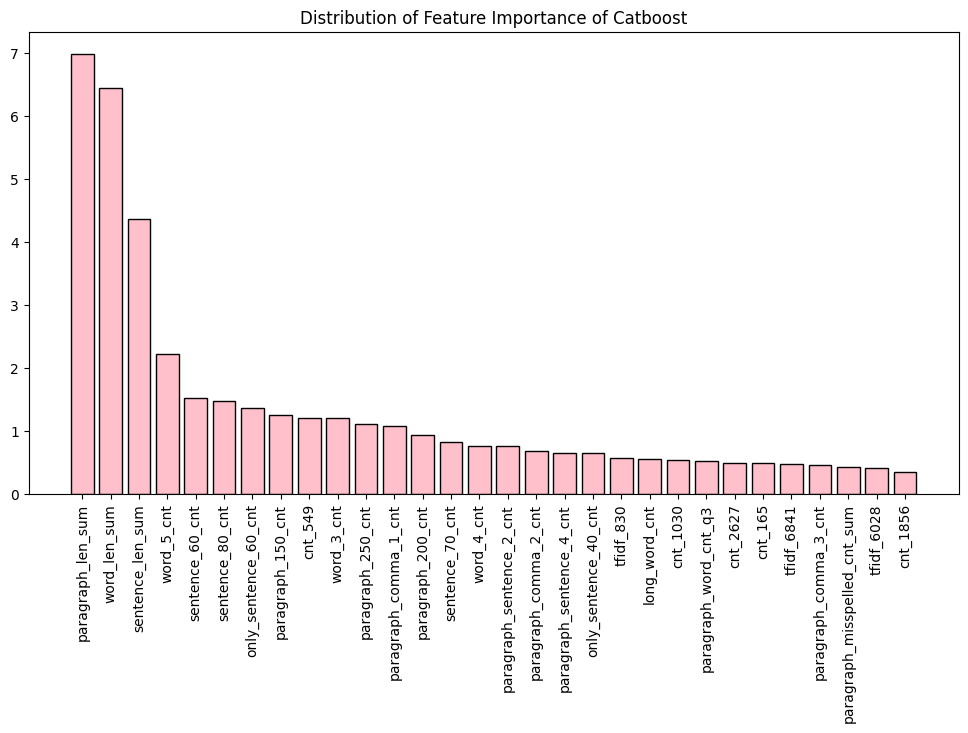

In [29]:
if CFG.LOAD_MODELS_FROM:
    model = pickle.load(open(f'{CFG.LOAD_MODELS_FROM}CAT_v{CFG.VER}_f0.pkl', 'rb'))
else: 
    model = pickle.load(open(f'CAT_v{CFG.VER}_f0.pkl', 'rb'))

df_importance = pd.DataFrame({
        'features_name': FEATURES,
        'importance': model.feature_importances_,
    })
df_importance = df_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(data=df_importance.head(30), x='features_name', height='importance', color='pink', edgecolor='black')
plt.title('Distribution of Feature Importance of Catboost')
plt.xticks(rotation=90)
plt.show()

In [30]:
test_a = test.with_columns(
         pl.col('full_text').map_elements(lambda x: dataPreprocessing(x))
     )
test_tfid = vectorizer.transform([i for i in test_a['full_text']])
dense_matrix = test_tfid.toarray()
df3 = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfidf_{i}' for i in range(len(df3.columns))]
df3.columns = tfid_columns
df3['essay_id'] = df_test['essay_id']

In [31]:
test_b = test.with_columns(
         pl.col('full_text').map_elements(lambda x: dataPreprocessing(x))
     )
test_cnt = vectorizer_cnt.transform([i for i in test_b['full_text']])
dense_matrix = test_cnt.toarray()
df4 = pd.DataFrame(dense_matrix)
cnt_columns = [ f'cnt_{i}' for i in range(len(df4.columns))]
df4.columns = cnt_columns
df4['essay_id'] = df_test['essay_id']

In [32]:
%%time 
test_feats1 = Paragraph_Features(test)
test_feats1 = Paragraph_aggregation(test_feats1)
test_feats2 = Sentence_Features(test)
test_feats2 = Sentence_aggregation(test_feats2)
test_feats3 = Word_Features(test)
test_feats3 = Word_aggregation(test_feats3)

Paragraph Preprocessing
Caculate the length of each paragraph
Caculate the number of sentences and words in each paragraph
Aggregation
Preprocess full_text and use periods to segment sentences in the text
Caculate the length of a sentence
Count the number of words in each sentence
Aggregation
Preprocess full_text and use spaces to seperate words fro the text
Caculate the length of a word
Aggregation
CPU times: user 65.2 ms, sys: 16.3 ms, total: 81.5 ms
Wall time: 125 ms


In [33]:
test_feats = test_feats1.merge(test_feats2, on='essay_id', how='left')
test_feats = test_feats.merge(test_feats3, on='essay_id', how='left')
test_feats = test_feats.merge(df3, on='essay_id', how='left')
test_feats = test_feats.merge(df4, on='essay_id', how='left')
print('Shape of test_feats:', test_feats.shape)
display(test_feats.head())

Shape of test_feats: (3, 13136)


,essay_id,paragraph_100_cnt,paragraph_150_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,paragraph_350_cnt,paragraph_400_cnt,paragraph_450_cnt,paragraph_500_cnt,...,cnt_4914,cnt_4915,cnt_4916,cnt_4917,cnt_4918,cnt_4919,cnt_4920,cnt_4921,cnt_4922,cnt_4923
0,000d118,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,000fe60,5,5,4,3,3,2,1,1,0,...,0,0,0,1,1,1,0,0,0,0
2,001ab80,4,4,4,4,4,4,4,4,3,...,0,2,2,0,0,0,0,0,0,0


In [34]:
preds = []
categorical_columns = test_feats.select_dtypes(include=['object','category']).columns.tolist()
FEATURES = [col for col in test_feats.columns if col not in categorical_columns]


for i in range(10):
    print(f'Fold {i+1}')
    if CFG.LOAD_MODELS_FROM:
        model = pickle.load(open(f'{CFG.LOAD_MODELS_FROM}CAT_v{CFG.VER}_f{i}.pkl', 'rb'))
    else: 
        model = pickle.load(open(f'CAT_v{CFG.VER}_f{i}.pkl', 'rb'))
        
        
    pred= model.predict(test_feats[FEATURES])

    
    preds.append(pred)
pred = np.mean(preds,axis=0)          
   

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [35]:
sub = pd.DataFrame({'essay_id': df_test.essay_id.values})
sub[TARGET] = pred.clip(1,6).round() 
sub.to_csv('submission.csv',index=False)
print('Submission shape', sub.shape)
sub.head()

Submission shape (3, 2)


,essay_id,score
0,000d118,2.0
1,000fe60,3.0
2,001ab80,4.0
